<a href="https://colab.research.google.com/github/musicjae/NLP/blob/master/seq2seq/Sequence_to_sequence_learning_with_neural_networks_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data load

In [ ]:
from IPython.display import Image

In [ ]:
from google.colab import files
uploaded = files.upload() # 파일 업로드 기능 실행

for fn in uploaded.keys(): # 업로드된 파일 정보 출력
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving addition.txt to addition.txt
User uploaded file "addition.txt" with length 650000 bytes


# 1. Intro

## 1.1 DNN의 한계 (Motivation)  
  
 기존의 DNN 방법론에서는 inputs과 targets은 **고정된 차원의 벡터**로만 인코딩될 수 있었다. 즉, DNN은 inputs과 outputs의 차원이 알려지고known, 고정된fixed 경우에만 잘 작동한다. 그러한 탓에, length가 미리 알려지지 않는 sequence를 다룰 때 이 한계는 문제적이었다. 

## 1.2 Core Idea  
  
#### 1.2.1 Aim:   
  LSTM (Long Short-term Memory) 아키텍처를 사용하는 것은 시퀀스 - 시퀀스 데이터를 다룰 때 나타나는 문제를 해결할 수 있다는 것을 보이고자 한다. 일반적으로 RNN(LSTM)을 이용하여 seq 형태의 입력을, seq 형태의 출력으로 데이터를 변환하는 작업을 seq2seq 라고 일컫는다.


#### 1.2.2  LSTM 사용 시 얻는 이점:  
  
  - (1) 긴 범위의 시간적 의존성을 가진 data를 문제없이 학습할 수 있다. (RNN이 이런 형태의 data 다룰 경우 vanishing gradient 현상이 나타나기도 한다)
  - (2) LSTM은 seq2seq에 적용될 때, input sentence를 거꾸로 읽는다. 이것은 최적화optimization 문제를 더 쉽게 만드는 many short-term dependencies를 도입하기 때문이다. (아래에서 다시 말하겠지만, 이 도입으로 인해 SGD는 LSTM을 문제없이 훈련시킨다.)  

### 1.2.3 seq2seq의 구조

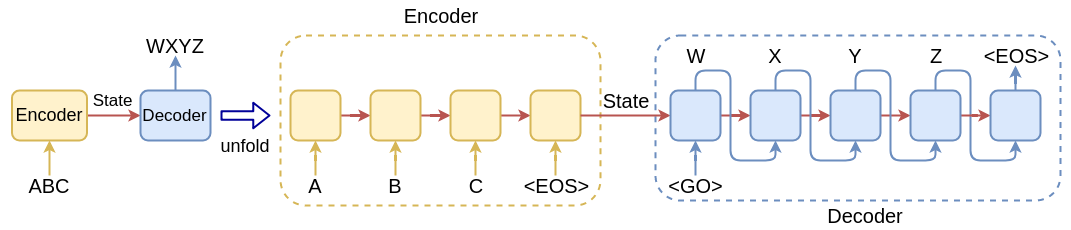

In [ ]:
Image('sq1.png')

**seq2seq**: 입력값을 시퀀스로 받고 (인코딩), 그것을 목적에 부합하게 변환한 뒤 다시 시퀀스 데이터로 출력(디코딩)한다. 그리고 인코더, 디코더는 LSTM로 설계될 수 있다.

## 1.3 Advantages  
  
seq2seq 사용 시 얻는 이점들:  
- 일종의 평가 지표인 BLEU 점수가 SMT 보다 더 높다  
- very long sentences를 다루는 데 문제를 겪지 않는다  
  > 왜냐하면 앞에서 말했듯이 (트레이닝 셋, 테스트 셋 내의 target 문장이 아닌) **source 문장** 내의 word의 순서를 뒤집는 전략이 위 같은 이점을 준다. 이 전략은 결과적으로 SGD가 LSTM을 문제없이 잘 훈련시키게 해준다.  
- seq2seq가 LSTM으로 구성됨에 따라 얻는 또 다른 이점은 <가변 길이의 input sequence>를 <고정된 차원의 벡터 표현>으로 맵핑하도록 학습시킨다는 것이다.


# 2. The model

## 2.1 RNN  
  
Long term dependency 경우에 RNN을 학습시키는 것은 어렵다.   
> - 이 경우에 gradient vanishing 또는 explosion이 나타날 수 있다.  
   - 해결 방안:   
   (1) gradient vanishing 경우에, gradient clipping 사용  
     (2) gradient explosion 경우에, LSTM 사용 (항상x)  


더 자세한 논의는 [5]의 1.3 참고

## 2.2 LSTM  
 우리는 위에서 보았던 RNN이 갖는 문제점을 개선하고, 또 다른 이점들을 얻기 위해 seq2seq에서 Vanila RNN 대신에 LSTM을 사용한다. ([1] 에서도 LSTM을 사용한다.)  
 LSTM 구현은 [7] 참고

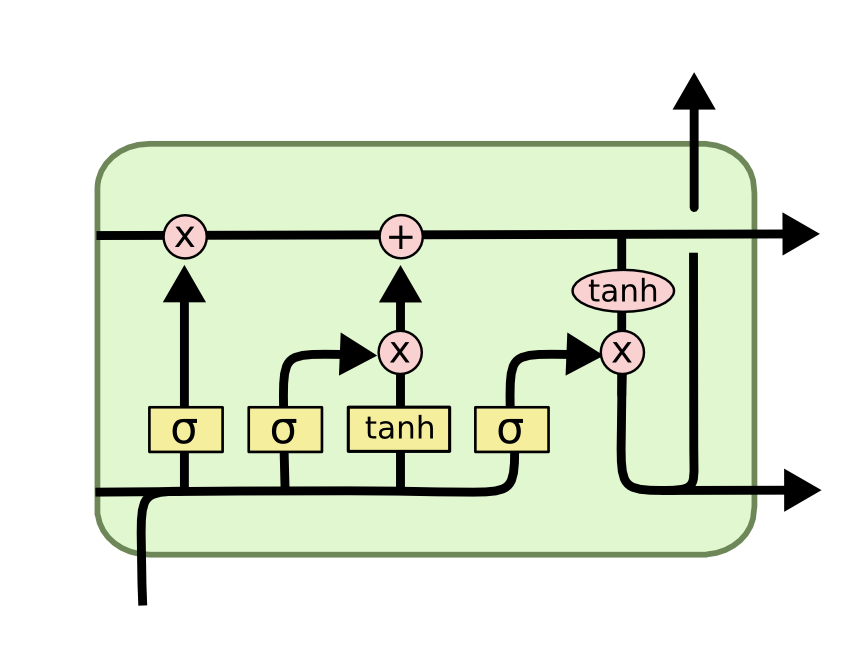

In [ ]:
Image('lstm.png',width=600)

## 2.3 EOS
  
각 문장은 <EOS> end of sentence 로 끝난다. 이것은 모델로 하여금 모든 가능한 길이의 seq에 대한 분포를 정의하게 해준다.

In [ ]:
import numpy as np
import sigmoid

class LSTM:
    def __init__(self, Wx, Wh, b):
        '''
        Parameters
        ----------
        Wx: 입력 x에 대한 가중치 
        Wh: 은닉 상태 h에 대한 가중치 매개변수
        b: 편향
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

## 2.4 seq2seq

### 2.4.1 Encoder

- Encoder: 시퀀스 입력 (e.g. 문장 내의 단어들) $\to$ 은닉 상태 벡터  
- LSTM의 은닉 상태 $h$는 **고정 길이 벡터**이다.  
  > 왜 인코딩 하는가? Ans) 임의의 길이의 문장(시퀀스) $\to$ 고정 길이 벡터

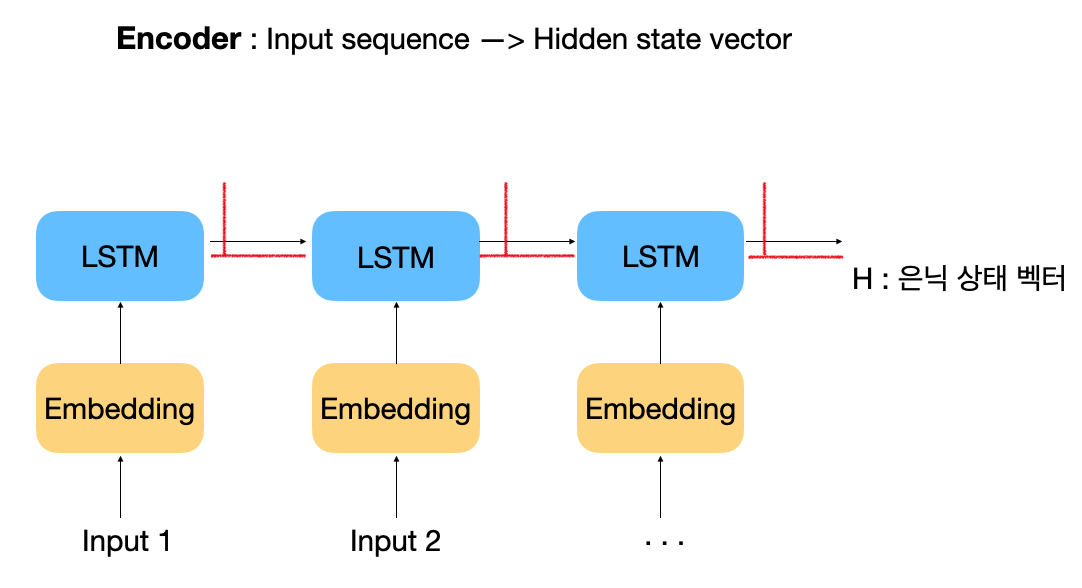

In [ ]:
Image('e1.png',width=800)

### 2.4.2 Decoder

- 인코더에서 만들어진 **은닉 상태 벡터 H**가 LSTM의 입력값으로 들어온다.  
- eos는 문장 생성의 시작과 끝을 알리기 위한 신호라고 간주될 수 있다.  
- 은닉 상태 벡터 H는 결국 인코더와 디코더를 이어주는 **다리** 역할을 한다고 이해될 수 있다.

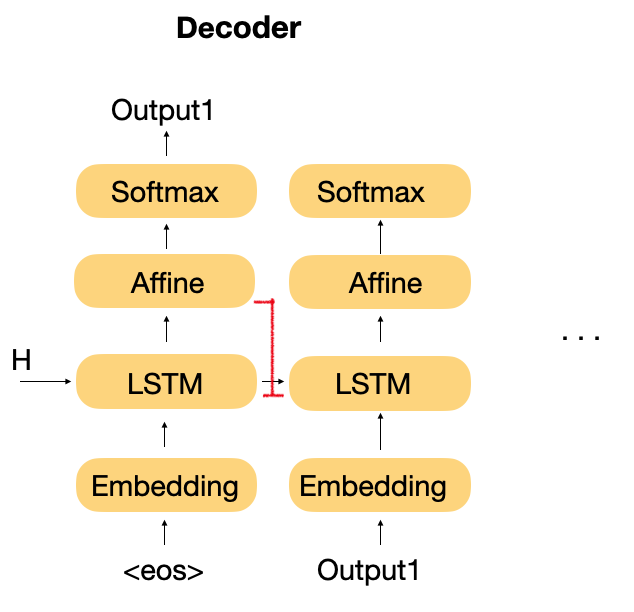

In [ ]:
Image('d1.png',width=600)

# 3. Toy problem with seq2seq

- Input: " number + number",  number in 0 - 999
- Output: "_number" , max length = 4
  
- Notice:  
  - 각각의 입력 문장의 문장 길이가 다르다  
  - 가변 길이의 시퀀스 $\to$ 미니배치로 학습 $\to$ (무의미한 데이터를 처리하기 위해) **패딩** 사용

#3. Actual application

 현실의 모델은 위 설명과 3 가지 다른 점이 있을 것이다.

- 1) 2 개의 다른 LSTM 사용 
  > 이렇게 하는 것은 적은 연산 비용으로 모델의 parameter의 개수를 늘릴 수 있다. 또한, 이것은 **동시에 여러 언어의 쌍**에 대한 LSTM을 훈련시키게 해준다.

#References. 

[1] Sutskever, Ilya, Oriol Vinyals, and Quoc V. Le. "Sequence to sequence learning with neural networks." Advances in neural information processing systems. 2014.  
[2] cs224n Lecture 8  
[3]https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html  
[4]https://github.com/Intelligence-Engineering-LAB-KU/Seminar/blob/master/summer_2020/0825_ysj_RNN_theory_and_LSTM.ipynb  
[5] https://github.com/Intelligence-Engineering-LAB-KU/Seminar/blob/master/summer_2020/0811_jjy_RNN_theory_and_practice.ipynb 
[6]https://github.com/rguthrie3/DeepLearningForNLPInPytorch/blob/master/Deep%20Learning%20for%20Natural%20Language%20Processing%20with%20Pytorch.ipynb 파이토치 튜토리얼  
[7]https://github.com/musicjae/cs231n/blob/master/assignment2/RNN_and_LSTM.ipynb RNN, LSTM 구현